# CIFAR-10 Demo - Image Classification

Welcome to Computer Vision! In this demo, you'll learn how computers can recognize objects in images.

## What You'll Learn:
1. **Image Classification Basics** - Teaching computers to recognize objects
2. **Feature Engineering** - The old-school approach (manually designed features)
3. **Data Augmentation** - Making models work in different conditions
4. **CNNs (Convolutional Neural Networks)** - The modern deep learning approach

---

## Setup: Import Libraries

**What are these?**
- **PyTorch**: A deep learning framework (like TensorFlow)
- **torchvision**: Computer vision tools for PyTorch
- **NumPy**: For numerical operations
- **Matplotlib**: For visualizing images
- **scikit-learn**: Traditional machine learning tools

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from skimage.feature import hog
from tqdm.notebook import tqdm

# Check what hardware we're using
# GPU (CUDA/MPS) is faster than CPU for deep learning
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Matplotlib is building the font cache; this may take a moment.


Using device: mps


## Part 1: Understanding the Data

**What is CIFAR-10?**

CIFAR-10 is a famous dataset used to teach computers image recognition. It contains 60,000 tiny color images.

**Key Facts:**
- **Image size**: 32×32 pixels (very small!)
- **10 classes**: airplane, car, bird, cat, deer, dog, frog, horse, ship, truck
- **50,000 training images**: Used to teach the model
- **10,000 test images**: Used to check how well the model learned

**Why so small?** Small images are harder to recognize (even for humans!), but they train faster. This helps us learn the concepts quickly.

In [2]:
# Load CIFAR-10 dataset
# ToTensor() converts images to tensors (multi-dimensional arrays that computers understand)
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Classes: {classes}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:22<00:00, 7.70MB/s]


Training images: 50000
Test images: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualize the Images

Let's look at one image from each class to see what we're working with!

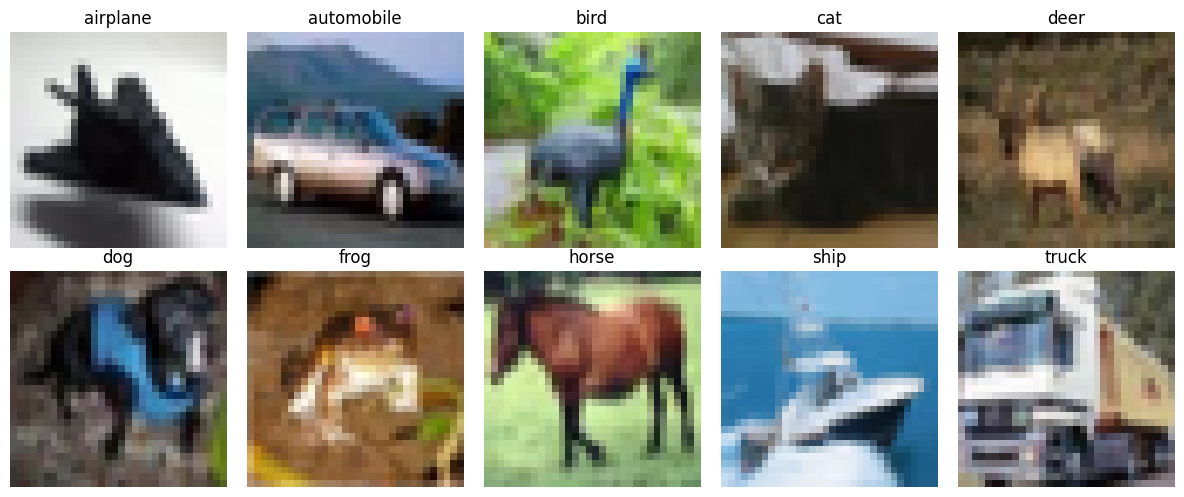


Image shape: torch.Size([3, 32, 32])
That's 3 color channels (RGB), 32 pixels tall, 32 pixels wide!


In [3]:
# Show one example from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, class_name in enumerate(classes):
    # Find first image of this class
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        if label == idx:
            ax = axes[idx // 5, idx % 5]
            # Convert tensor (C, H, W) to numpy (H, W, C) for display
            img_np = img.permute(1, 2, 0).numpy()
            ax.imshow(img_np)
            ax.set_title(class_name)
            ax.axis('off')
            break
plt.tight_layout()
plt.show()

# Check image dimensions
sample_img, _ = train_dataset[0]
print(f"\nImage shape: {sample_img.shape}")  # (channels, height, width)
print("That's 3 color channels (RGB), 32 pixels tall, 32 pixels wide!")

## Part 2: Feature Engineering (The Old Way)

**The Big Idea:** Before deep learning, humans had to manually tell computers what to look for.

**How it works:**
1. **Humans design features** - We decide what's important (edges, shapes, colors)
2. **Extract features** - Use algorithms to measure these things in images
3. **Train a simple classifier** - Teach it to recognize patterns in the features

**Example Algorithm: HOG (Histogram of Oriented Gradients)**
- Detects edges and their directions in the image
- Converts an image into a list of numbers describing its edges

**The Problem:**
- Humans aren't good at knowing what features matter!
- Performance is limited (~40-50% accuracy on CIFAR-10)
- That's why deep learning took over!

In [4]:
def extract_hog_features(dataset, num_samples=5000):
    """
    Extract HOG features from images
    
    HOG finds edges in images and describes them with numbers.
    Think of it like describing a person: "tall, brown hair, glasses"
    """
    features = []
    labels = []
    
    for i in tqdm(range(min(num_samples, len(dataset))), desc="Extracting features"):
        img, label = dataset[i]
        # Convert to grayscale (black & white) for HOG
        img_gray = img.mean(dim=0).numpy()
        
        # Extract HOG features
        feat = hog(img_gray, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9)
        
        features.append(feat)
        labels.append(label)
    
    return np.array(features), np.array(labels)

# Extract features (using small subset for speed)
print("Extracting HOG features from training data...")
X_train, y_train = extract_hog_features(train_dataset, num_samples=5000)
print("Extracting HOG features from test data...")
X_test, y_test = extract_hog_features(test_dataset, num_samples=2000)

print(f"\nEach image is now represented by {X_train.shape[1]} numbers")
print("These numbers describe the edges and shapes in the image")

Extracting HOG features from training data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

Extracting HOG features from test data...


Extracting features:   0%|          | 0/2000 [00:00<?, ?it/s]


Each image is now represented by 1764 numbers
These numbers describe the edges and shapes in the image


### Train a Classifier on HOG Features

Now we'll train a **Logistic Regression** model on these features.

**What is Logistic Regression?**
- A simple machine learning algorithm
- Draws lines to separate different classes
- Works well for simple problems

In [5]:
print("Training classifier on HOG features...")
clf = LogisticRegression(max_iter=100, verbose=1)
clf.fit(X_train, y_train)

# Evaluate performance
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(f"\n{'='*50}")
print("FEATURE ENGINEERING RESULTS")
print(f"{'='*50}")
print(f"Train Accuracy: {train_acc:.1%}")
print(f"Test Accuracy:  {test_acc:.1%}")
print(f"{'='*50}")
print("\n💡 Not great! Manual features can only do so much.")
print("   This is why deep learning became popular!")

Training classifier on HOG features...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17650     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  1.09987D-02


 This problem is unconstrained.



At iterate   50    f=  9.42099D-01    |proj g|=  1.79314D-02

At iterate  100    f=  8.38094D-01    |proj g|=  2.28693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17650    100    108      1     0     0   2.287D-03   8.381D-01
  F =  0.83809350262570614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

FEATURE ENGINEERING RESULTS
Train Accuracy: 81.4%
Test Accuracy:  41.6%

💡 Not great! Manual features can only do so much.
   This is why deep learning became popular!


/Users/mikeynguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


## Part 3: Data Augmentation (The Secret Weapon)

**The Problem:** Real-world images vary a lot:
- Different lighting (bright, dark, sunny, cloudy)
- Different angles (front view, side view, tilted)
- Different positions (centered, off to the side)
- Different colors (faded, vibrant)

If we only train on the original images, the model might not recognize objects in different conditions!

**The Solution: Data Augmentation**

Create variations of training images by randomly:
- **Flipping** them horizontally
- **Cropping** different parts
- **Rotating** slightly
- **Changing colors** (brightness, contrast)

**Why This Matters:**
- Forces the model to learn features that work under ANY conditions
- Dramatically improves performance on new images
- **This is KEY for the competition!**

**Real-World Analogy:**

Imagine learning to recognize your friend:
- If you only see them in one outfit, one lighting, one angle → you might not recognize them elsewhere
- If you see them in many situations → you'll always recognize them

That's what data augmentation does for AI!

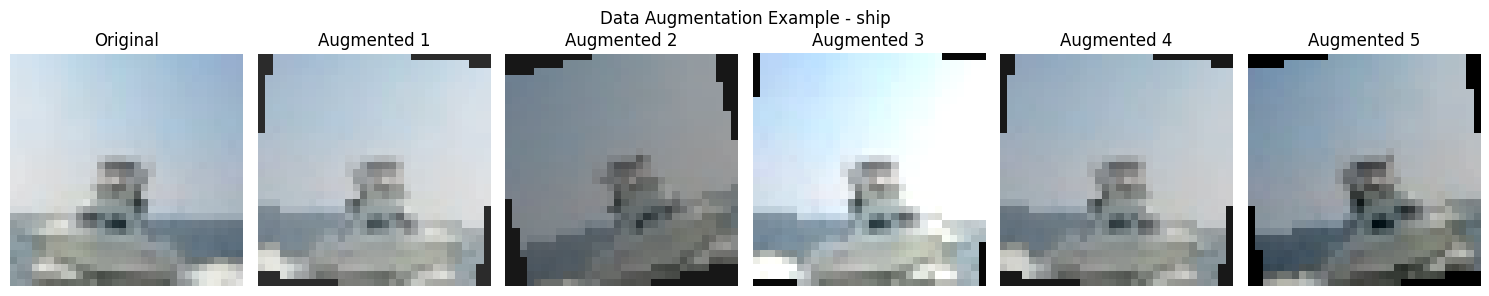


💡 The model sees many variations of each image during training!
   This helps it learn robust features that work in different conditions.


In [6]:
# Let's see what augmentation looks like!

# Define augmentation transforms
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip for demo
    transforms.RandomRotation(15),  # Rotate up to 15 degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjust colors
    transforms.ToTensor()
])

# Get one image
original_img, label = train_dataset[100]

# Show original + 5 augmented versions
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

axes[0].imshow(original_img.permute(1, 2, 0))
axes[0].set_title("Original")
axes[0].axis('off')

# Generate augmented versions
for i in range(1, 6):
    from PIL import Image
    pil_img = Image.fromarray((original_img.permute(1,2,0).numpy() * 255).astype(np.uint8))
    aug_img = augment_transform(pil_img)
    axes[i].imshow(aug_img.permute(1, 2, 0))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.suptitle(f"Data Augmentation Example - {classes[label]}")
plt.tight_layout()
plt.show()

print("\n💡 The model sees many variations of each image during training!")
print("   This helps it learn robust features that work in different conditions.")

## Part 4: Convolutional Neural Networks (The Modern Way)

**The Big Idea:** Instead of humans designing features, let the computer learn them automatically!

**What is a CNN?**

A CNN is a type of neural network that learns a hierarchy of features:

1. **Layer 1**: Learns simple patterns (edges, lines, colors)
2. **Layer 2**: Combines simple patterns into parts (wheels, eyes, wings)
3. **Layer 3**: Combines parts into objects (car, cat, bird)

**Key Components:**

- **Convolutional Layers (Conv2d)**: Learn filters that detect patterns
  - Like Instagram filters, but learned automatically!
  
- **ReLU (Activation)**: Adds non-linearity
  - Allows the network to learn complex patterns
  
- **Pooling Layers (MaxPool)**: Reduce size, keep important info
  - Like creating a summary of a book
  
- **Fully Connected Layers**: Make final decision
  - Combines all learned features to classify the image

**Advantages:**
- No manual feature design needed!
- Learns optimal features automatically
- Much better performance (~70-80%+ on CIFAR-10)

In [7]:
class SimpleCNN(nn.Module):
    """
    A simple CNN with 3 convolutional blocks
    
    Architecture:
    Block 1: Conv -> ReLU -> Pool (learns simple edges)
    Block 2: Conv -> ReLU -> Pool (learns shapes)
    Block 3: Conv -> ReLU -> Pool (learns objects)
    Classifier: Dropout -> Linear (makes final decision)
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1: Detect simple patterns (edges, colors)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 input channels (RGB) -> 32 filters
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduce size: 32×32 -> 16×16
            
            # Block 2: Detect complex patterns (shapes, textures)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 -> 64 filters
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduce size: 16×16 -> 8×8
            
            # Block 3: Detect high-level patterns (object parts)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 64 -> 128 filters
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global pooling: 8×8 -> 1×1
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Randomly turn off 50% of neurons (prevents overfitting)
            nn.Linear(128, 10)  # 128 features -> 10 class scores
        )
    
    def forward(self, x):
        """Pass input through the network"""
        x = self.features(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten to 1D
        x = self.classifier(x)  # Classify
        return x

# Create the model
model = SimpleCNN().to(device)
print("Model created!")
print(f"Number of learnable parameters: {sum(p.numel() for p in model.parameters()):,}")
print("These are the numbers the model will learn during training!")

Model created!
Number of learnable parameters: 94,538
These are the numbers the model will learn during training!


### Prepare Data with Augmentation

Now we'll create two versions of the data:
- **Training data**: WITH augmentation (to learn robust features)
- **Test data**: WITHOUT augmentation (to fairly evaluate performance)

In [ ]:
# Training transforms: WITH augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Test transforms: WITHOUT augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset_aug = datasets.CIFAR10(root='./data', train=True, transform=train_transform)
test_dataset_norm = datasets.CIFAR10(root='./data', train=False, transform=test_transform)

# Create data loaders (feed data to model in batches)
train_loader = DataLoader(train_dataset_aug, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset_norm, batch_size=256, shuffle=False, num_workers=2)

print("Data ready!")

### Train the Model!

**How Training Works:**

1. **Forward Pass**: Show images to the model, get predictions
2. **Calculate Loss**: Measure how wrong the predictions are
3. **Backward Pass**: Calculate how to adjust each parameter to reduce loss
4. **Update Weights**: Adjust parameters to make better predictions
5. **Repeat**: Do this thousands of times!

**Key Concepts:**
- **Loss Function**: Measures prediction error
- **Optimizer**: Updates model weights (we use Adam)
- **Epoch**: One complete pass through all training data

In [ ]:
# Loss function: Measures how wrong predictions are
criterion = nn.CrossEntropyLoss()

# Optimizer: Updates model weights to reduce loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()  # Set to training mode
    total, correct = 0, 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights
        
        # Track accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

def test(model, loader, device):
    """Evaluate the model"""
    model.eval()  # Set to evaluation mode
    total, correct = 0, 0
    
    with torch.no_grad():  # Don't calculate gradients (saves memory)
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

# Train for 5 epochs
print("Starting training...\n")
for epoch in range(1, 6):
    print(f"Epoch {epoch}/5")
    train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Test Accuracy:  {test_acc:.2f}%\n")

print("\n" + "="*50)
print("FINAL CNN RESULTS")
print("="*50)
print(f"Final Test Accuracy: {test_acc:.2f}%")
print("="*50)
print("\n💡 Much better than feature engineering (~40%)!")
print("   CNNs learn the best features automatically!")

## Summary: What We Learned

### 1. Feature Engineering (Old Way)
- ❌ Humans manually design features
- ❌ Limited performance (~40-50%)
- ❌ Requires expert knowledge

### 2. Data Augmentation (The Secret)
- ✅ Create variations of training images
- ✅ Forces model to learn robust features
- ✅ **KEY INSIGHT**: If test data varies, train with variations!

### 3. CNNs (Modern Way)
- ✅ Automatically learns features
- ✅ Much better performance (~70-80%+)
- ✅ No manual feature design needed

---

## For the Competition (CIFAR-100)

**What's Different?**
- 100 classes instead of 10 (much harder!)
- Test set will have challenging augmentations

**How to Win?**
1. **Data augmentation is CRITICAL!** Add more augmentations to training
2. **Improve the model** - Add more layers, try BatchNorm, experiment!
3. **Train longer** - 20-50 epochs instead of 5
4. **Tune hyperparameters** - Learning rate, batch size, optimizer

**Remember:** Models trained with augmentation generalize better to augmented test sets!

Good luck! 🚀